PARTE TEORICA: https://docs.google.com/document/d/1kLI5kNDR7UBccx7k3dr6lu7GCoXK3JEESKqzG3BdhM0/edit

# PdS - Examen

En el archivo TRIBICsignal.csv, se adquirió mediante un conversor AD la señal de un detector de iones.

El detector tiene un nivel de base, el cual Cuando una partícula ionizada impacta sobre el detector, se inducen cargas que generan un incremento de la señal, con una forma similar a la de una exponencial negativa. Sobre la misma, siempre existe ruido generado por componentes de alta frecuencia que no aportan información.

Las condiciones del muestreo son:

    Fs=10MHz
    N=512
    
Para trabajar con las muestras en Python, a continuación se obtienen las muestras de la señal y se representa la misma en un gráfico.

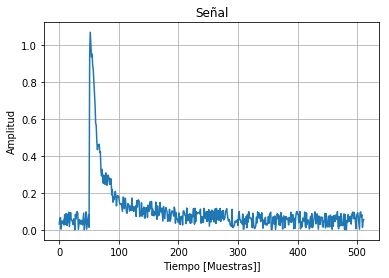

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as sc
from scipy import signal as sig

signal = np.genfromtxt('TRIBICsignal.csv',delimiter=",")

plt.figure
plt.plot(signal)

plt.title('Señal')
plt.xlabel('Tiempo [Muestras]')
plt.ylabel('Amplitud')
plt.grid(which='both', axis='both')

plt.show()


# Análisis de señal

1) Obtener el espectro de la señal muestreada.

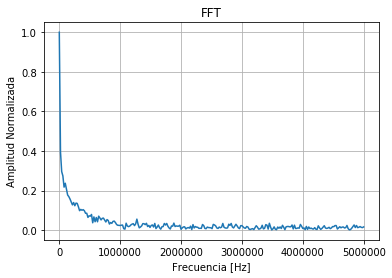

In [7]:
fs = 10000000 #10 MHz
ts = 1/fs

N = len(signal)
tt = np.linspace(0.0, (N-1)*ts, N).flatten()
ff = np.linspace(0.0, fs/2, N//2).flatten()


spectrum = np.abs(sc.fft(signal,axis=0))
spectrum = (1/max(spectrum))*spectrum
halfSpectrum = spectrum[:N//2] 

plt.figure(2)
plt.plot(ff, halfSpectrum)

plt.title('FFT')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud Normalizada')
plt.grid(which='both', axis='both')

plt.show()

2) Calcular la energía de su espectro.

In [14]:
energy = 2 * sum ( abs ( halfSpectrum ) ** 2)

print('Energia del espectro: ', energy)

Energia del espectro:  3.7787527510795362


3) En base a los puntos 1) y 2), estime el ancho de banda de señal explicando el criterio empleado.  

El ancho de banda es la longitud (en Hz) de frecuencias en la que se encuentra la mayor cantidad de potencia de la señal. Siendo que luego de 1 MHz las componentes de frecuencia practicamente tienen un peso nulo, puedo afirmar que el ancho de banda de la señal es de 2 MHz.

Ademas Fs > 2B (teorma de Nyquist-Shannon) se cumple perfectamente al tener: 10 MHz > 2 * 2 Mhz -> 10 MHz > 4 MHz.

# Filtrado de ruido

4) En los archivos filter_a.csv, filter_b.csv y filter_c.csv se encuentran almacenados los coeficientes correspondientes a las respectivas h[n] de tres filtros tipo FIR.

* Obtenga la respuesta de módulo y especifique de qué tipo de filtro se trata (pasabajos, pasaaltos, pasabanda, etc)

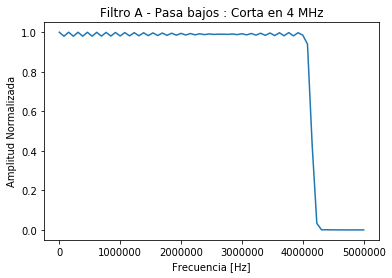

In [18]:
filter_a = np.loadtxt('filter_a.csv')

N_a = len(filter_a)
tt_a = np.linspace(0.0, (N_a-1)*ts, N_a).flatten()
ff_a = np.linspace(0.0, fs/2, N_a//2).flatten()

spectrum_a = np.abs(sc.fft(filter_a,axis=0))
spectrum_a = (1/max(spectrum_a))*spectrum_a
halfSpectrum_a = spectrum_a[:N_a//2] 

plt.figure(3)
plt.plot(ff_a, halfSpectrum_a)

plt.title('Filtro A - Pasa bajos : Corta en 4 MHz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud Normalizada')
plt.show()

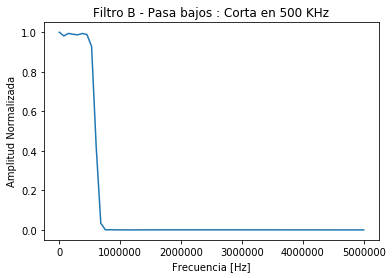

In [19]:
filter_b = np.loadtxt('filter_b.csv')

N_b = len(filter_b)
tt_b = np.linspace(0.0, (N_b-1)*ts, N_b).flatten()
ff_b = np.linspace(0.0, fs/2, N_b//2).flatten()

spectrum_b = np.abs(sc.fft(filter_b,axis=0))
spectrum_b = (1/max(spectrum_b))*spectrum_b
halfSpectrum_b = spectrum_b[:N_b//2] 

plt.figure(4)
plt.plot(ff_b, halfSpectrum_b)

plt.title('Filtro B - Pasa bajos : Corta en 500 KHz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud Normalizada')
plt.show()

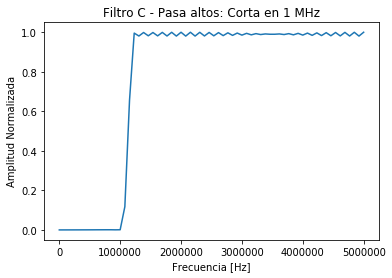

In [20]:
filter_c = np.loadtxt('filter_c.csv')

N_c = len(filter_c)
tt_c = np.linspace(0.0, (N_c-1)*ts, N_c).flatten()
ff_c = np.linspace(0.0, fs/2, N_c//2).flatten()

spectrum_c = np.abs(sc.fft(filter_c,axis=0))
spectrum_c = (1/max(spectrum_c))*spectrum_c
halfSpectrum_c = spectrum_c[:N_a//2] 

plt.figure(5)
plt.plot(ff_c, halfSpectrum_c)

plt.title('Filtro C - Pasa altos: Corta en 1 MHz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud Normalizada')
plt.show()

* En función de las respuestas obtenidas en a), decida cuál de ellos es más adecuada para eliminar el ruido de alta frecuencia de la señal observada en el punto 1)

Filtro C : NO podría servir para este problema porque practicamente TODA la señal útil se encuentra antes de los 10 MHz y sería filtrada la señal útil y pasaría el ruido.

Filtro A : No podría servir porque aunque preserva la señal útil, todo el ruido entre 10 MHz y 40 MHz también pasaría.

Filtro B : Sería el mas posible filtro a utilizar, siendo que gran parte de la señal útil se encuentra entre 0  y 10 MHz solo se perdería una pequeña porción de los armónicos cercanos a éste último valor. Ademas de filtrar todo el ruido de alta frecuencia.

5) Filtre la señal de entrada con el filtro elegido, y grafique el nuevo espectro obtenido. Compare con el espectro obtenido en 1).

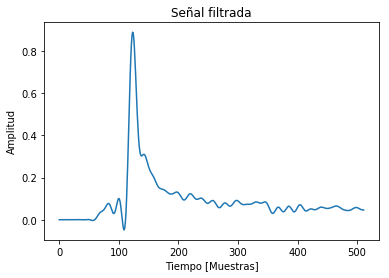

In [26]:
a_pb_fir = np.array([1])

yFIR = sig.lfilter(filter_b,a_pb_fir,signal.flatten())

plt.figure(6)

plt.plot(yFIR)
plt.title('Señal filtrada')
plt.xlabel('Tiempo [Muestras]')
plt.ylabel('Amplitud')
plt.show()

# Detección de eventos

6) En función de la representación temporal de la señal, proponga un método de detección que permita encontrar el inicio del pulso visualizado, empleando un filtro sencillo.

In [32]:
# Considerando 0.4 como la amplitud de señal a la cual considero un pulso

trigger = np.zeros(N)

for i in range(N):
    if yFIR[i] > 0.4:
        trigger[i] = 1
    else:
        trigger[i] = 0

7) Aplíquelo sobre la señal 

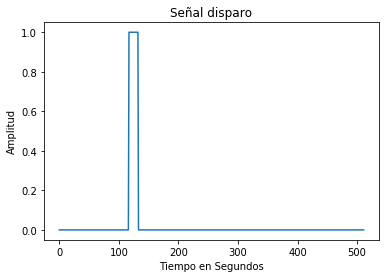

In [33]:
plt.figure(7)
plt.plot(trigger)
plt.title('Señal disparo')
plt.xlabel('Tiempo en Segundos')
plt.ylabel('Amplitud')
plt.show()